In [1]:
import torch
import os
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import logging

c:\Users\mkahs\GIT_REPO\2025_projects\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, confusion_matrix, accuracy_score

# Load dataset
df = pd.read_csv("twitter_data/stock_data.csv")  # Update with the correct path if necessary

# Display dataset shape and first few rows
print(df.shape)
df.head()


(5791, 2)


,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

# Apply text cleaning
df['Cleaned_Text'] = df['Text'].apply(clean_text)

# Splitting the dataset (70% Train, 20% Validation, 10% Test)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Sentiment'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=1/3, stratify=temp_df['Sentiment'], random_state=42)

# Print distribution
print("Training Set:", train_df['Sentiment'].value_counts())
print("Validation Set:", val_df['Sentiment'].value_counts())
print("Testing Set:", test_df['Sentiment'].value_counts())


Training Set: Sentiment
 1    2579
-1    1474
Name: count, dtype: int64
Validation Set: Sentiment
 1    737
-1    421
Name: count, dtype: int64
Testing Set: Sentiment
 1    369
-1    211
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mkahs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train = vectorizer.fit_transform(train_df['Cleaned_Text']).toarray()
X_val = vectorizer.transform(val_df['Cleaned_Text']).toarray()
X_test = vectorizer.transform(test_df['Cleaned_Text']).toarray()

y_train = train_df['Sentiment'].values
y_val = val_df['Sentiment'].values
y_test = test_df['Sentiment'].values

print("TF-IDF Transformation Complete!")


TF-IDF Transformation Complete!


In [7]:
def train_and_evaluate(model, model_name):
    start_time = time.time()
    
    # Train Model
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Evaluation Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    acc = accuracy_score(y_test, y_pred)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Print Metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    if auc_score:
        print(f"AUC Score: {auc_score:.4f}")
    
    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # ROC Curve
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

    return model_name, acc, precision, recall, f1, auc_score, train_time


Model: Random Forest
Accuracy: 0.7810
Precision: 0.7854
Recall: 0.9024
F1-score: 0.8398
AUC Score: 0.8387


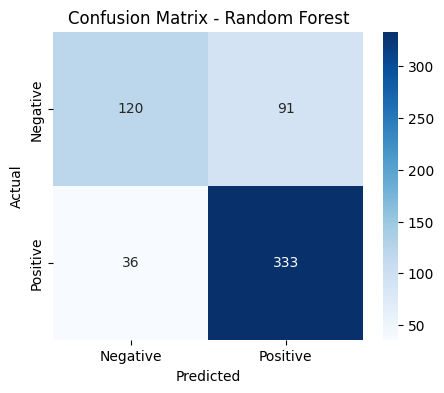

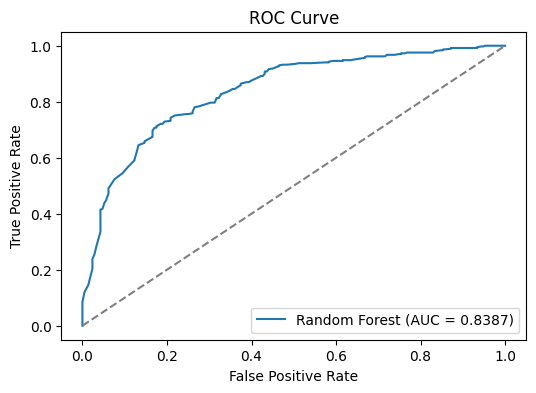

Model: Logistic Regression
Accuracy: 0.7569
Precision: 0.7533
Recall: 0.9187
F1-score: 0.8278
AUC Score: 0.8380


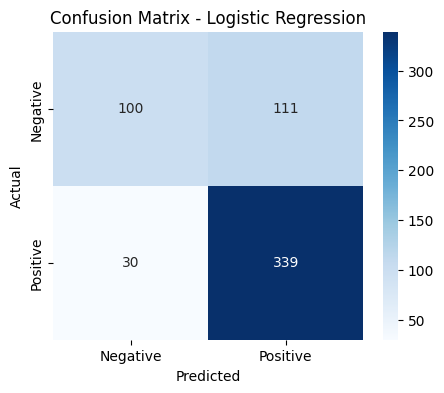

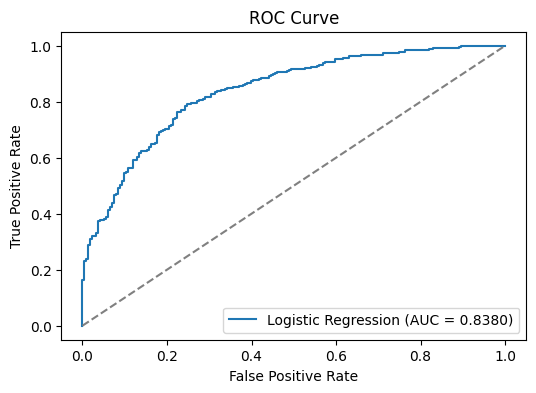

Model: SVM
Accuracy: 0.7741
Precision: 0.7680
Recall: 0.9241
F1-score: 0.8389
AUC Score: 0.8506


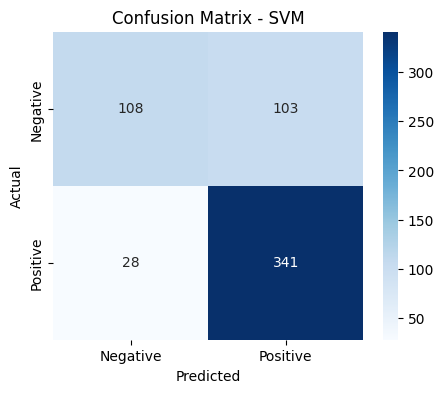

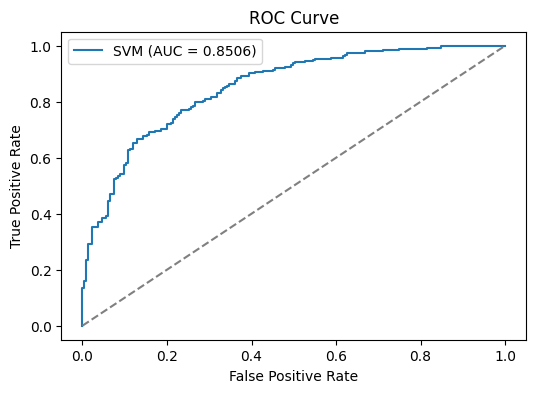

Model: Gradient Boosting
Accuracy: 0.7414
Precision: 0.7248
Recall: 0.9566
F1-score: 0.8248
AUC Score: 0.7940


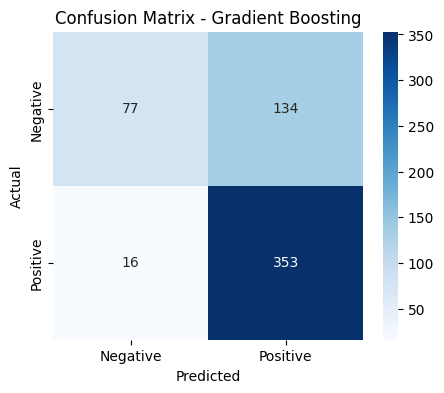

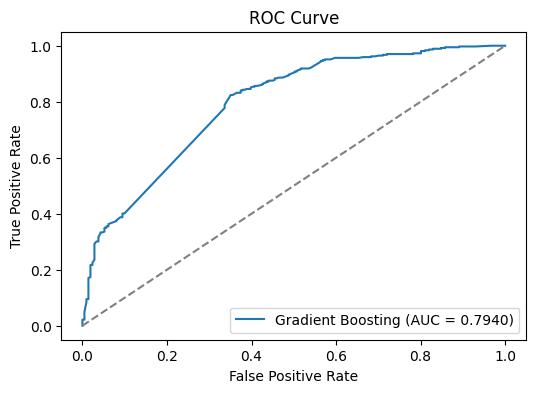

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = [
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (SVC(probability=True), "SVM"),
    (GradientBoostingClassifier(n_estimators=100), "Gradient Boosting")
]

results = []
for model, name in models:
    result = train_and_evaluate(model, name)
    results.append(result)


In [11]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


Epoch 1/5


c:\Users\mkahs\GIT_REPO\2025_projects\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 1041s 8s/step - accuracy: 0.0266 - loss: 0.6095 - val_accuracy: 0.0000e+00 - val_loss: 0.5863
Epoch 2/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 1018s 8s/step - accuracy: 0.0000e+00 - loss: 0.6260 - val_accuracy: 0.0000e+00 - val_loss: 0.5883
Epoch 3/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 1024s 8s/step - accuracy: 0.0000e+00 - loss: 0.5870 - val_accuracy: 0.0000e+00 - val_loss: 0.5887
Epoch 4/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 16066s 127s/step - accuracy: 0.0000e+00 - loss: 0.6165 - val_accuracy: 0.0000e+00 - val_loss: 0.5876
Epoch 5/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 1062s 8s/step - accuracy: 0.0000e+00 - loss: 0.6260 - val_accuracy: 0.0000e+00 - val_loss: 0.5868


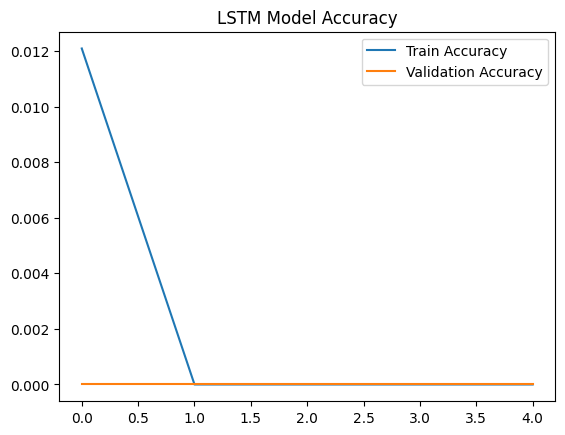

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GRU

max_features = 5000
embedding_dim = 128
sequence_length = X_train.shape[1]

def build_lstm_model():
    model = Sequential([
        Embedding(max_features, embedding_dim, input_length=sequence_length),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train LSTM
lstm_model = build_lstm_model()
history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("LSTM Model Accuracy")
plt.legend()
plt.show()


Epoch 1/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.0257 - loss: 0.6010 - val_accuracy: 0.0000e+00 - val_loss: 0.6092
Epoch 2/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.0000e+00 - loss: 0.5928 - val_accuracy: 0.0000e+00 - val_loss: 0.5872
Epoch 3/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 2056s 16s/step - accuracy: 0.0000e+00 - loss: 0.5936 - val_accuracy: 0.0000e+00 - val_loss: 0.5920
Epoch 4/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.0000e+00 - loss: 0.6303 - val_accuracy: 0.0000e+00 - val_loss: 0.5889
Epoch 5/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.0000e+00 - loss: 0.5868 - val_accuracy: 0.0000e+00 - val_loss: 0.5884


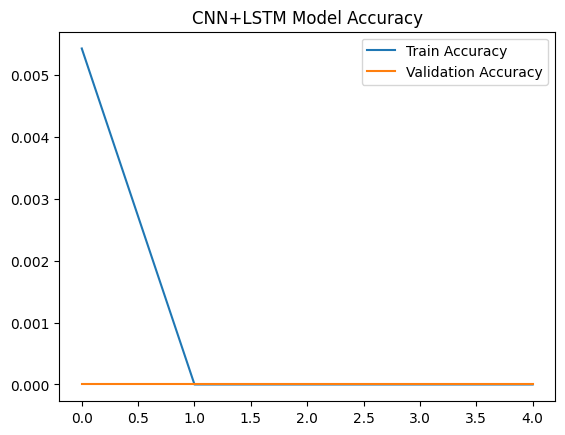

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Define model parameters
max_features = 5000  # Should match TF-IDF vectorizer max_features
embedding_dim = 128
sequence_length = X_train.shape[1]

# CNN+LSTM Model
def build_cnn_lstm():
    model = Sequential([
        Embedding(max_features, embedding_dim, input_length=sequence_length),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_lstm_model = build_cnn_lstm()

# Train the model
history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Plot Training History
plt.plot(history_cnn_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN+LSTM Model Accuracy")
plt.legend()
plt.show()


In [14]:
from tensorflow.keras.layers import GRU

# GRU Model
def build_gru():
    model = Sequential([
        Embedding(max_features, embedding_dim, input_length=sequence_length),
        GRU(128, return_sequences=True),
        GRU(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

gru_model = build_gru()

# Train the model
history_gru = gru_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Plot Training History
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title("GRU Model Accuracy")
plt.legend()
plt.show()


Epoch 1/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3351s 26s/step - accuracy: 0.0025 - loss: 0.6163 - val_accuracy: 0.0000e+00 - val_loss: 0.5867
Epoch 2/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3338s 26s/step - accuracy: 0.0000e+00 - loss: 0.5791 - val_accuracy: 0.0000e+00 - val_loss: 0.5862
Epoch 3/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 5067s 40s/step - accuracy: 0.0000e+00 - loss: 0.6070 - val_accuracy: 0.0000e+00 - val_loss: 0.5961
Epoch 4/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 1655s 13s/step - accuracy: 0.0000e+00 - loss: 0.6061 - val_accuracy: 0.0000e+00 - val_loss: 0.5886
Epoch 5/5
  5/127 ━━━━━━━━━━━━━━━━━━━━ 83:11:37 2455s/step - accuracy: 0.0000e+00 - loss: 0.6346 

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_auc_score, roc_curve, confusion_matrix

def evaluate_deep_learning_model(model, model_name):
    start_time = time.time()
    
    # Predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary labels
    
    train_time = time.time() - start_time

    # Compute Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n🔹 Model: {model_name}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1-score: {f1:.4f}")
    print(f"✅ AUC Score: {auc_score:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return model_name, acc, precision, recall, f1, auc_score, train_time


In [ ]:
# Evaluate CNN+LSTM
cnn_lstm_results = evaluate_deep_learning_model(cnn_lstm_model, "CNN+LSTM")

# Evaluate GRU
gru_results = evaluate_deep_learning_model(gru_model, "GRU")


In [ ]:
# Convert existing results list into DataFrame if not already done
if 'results_df' not in globals():
    results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "Training Time"])

# Append new results (CNN+LSTM and GRU)
new_results = pd.DataFrame([cnn_lstm_results, gru_results], columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "Training Time"])
results_df = pd.concat([results_df, new_results], ignore_index=True)

# Save to CSV
results_df.to_csv("model_comparison_results.csv", index=False)
print("\n📂 Model results saved to model_comparison_results.csv!")

# Display results
results_df.head()


In [ ]:
# from tensorflow.keras.layers import LSTM

# # LSTM Model
# def build_lstm():
#     model = Sequential([
#         Embedding(max_features, embedding_dim, input_length=sequence_length),
#         LSTM(128, return_sequences=True),
#         LSTM(64),
#         Dense(64, activation='relu'),
#         Dropout(0.5),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# lstm_model = build_lstm()

# # Train LSTM
# history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# # Plot Training History
# plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
# plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
# plt.title("LSTM Model Accuracy")
# plt.legend()
# plt.show()


In [ ]:
# Evaluate LSTM
lstm_results = evaluate_deep_learning_model(lstm_model, "LSTM")

# Append LSTM results to results_df
new_results = pd.DataFrame([lstm_results], columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "Training Time"])
results_df = pd.concat([results_df, new_results], ignore_index=True)

# Save updated results
results_df.to_csv("model_comparison_results.csv", index=False)
print("\n📂 Updated model results saved to model_comparison_results.csv!")

# Display final results
results_df.head()


In [ ]:
# results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "Training Time"])
# results_df.to_csv("model_comparison_results.csv", index=False)
# print("Results saved!")
# results_df.head(50)


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Function to evaluate transformer models
def evaluate_transformer_model(model_name):
    # Load Tokenizer & Model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    
    # Tokenize Text
    encoded_test = tokenizer(list(test_df['Cleaned_Text']), padding=True, truncation=True, return_tensors="pt", max_length=512)
    
    # Convert to Tensor Dataset
    input_ids = encoded_test["input_ids"]
    attention_mask = encoded_test["attention_mask"]
    
    dataset = TensorDataset(input_ids, attention_mask)
    dataloader = DataLoader(dataset, batch_size=16)
    
    # Predict Sentiment
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=1)[:, 1]  # Get probability of positive class
            predictions.extend(probs.cpu().numpy())
    
    y_pred_proba = np.array(predictions)
    y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary labels

    # Compute Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n🔹 Model: {model_name}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1-score: {f1:.4f}")
    print(f"✅ AUC Score: {auc_score:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return model_name, acc, precision, recall, f1, auc_score, "Pretrained"


In [ ]:
transformer_models = [
    "distilbert-base-uncased-finetuned-sst-2-english",  # DistilBERT
    "roberta-base",  # RoBERTa
    "ProsusAI/finbert",  # FinBERT
    "xlnet-base-cased"  # XLNet
]

transformer_results = []
for model_name in transformer_models:
    result = evaluate_transformer_model(model_name)
    transformer_results.append(result)


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def evaluate_vader():
    sia = SentimentIntensityAnalyzer()
    
    # Predict Sentiment
    y_pred_proba = np.array([sia.polarity_scores(text)['compound'] for text in test_df['Cleaned_Text']])
    y_pred = (y_pred_proba > 0).astype(int)  # Convert VADER score into binary label
    
    # Compute Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print("\n🔹 Model: VADER")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1-score: {f1:.4f}")
    print(f"✅ AUC Score: {auc_score:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - VADER")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"VADER (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return "VADER", acc, precision, recall, f1, auc_score, "Lexicon-Based"

# Run VADER
vader_results = evaluate_vader()


In [ ]:
# Convert results list to DataFrame if not already done
if 'results_df' not in globals():
    results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "Training Time"])

# Append Transformer and VADER results
new_results = pd.DataFrame(transformer_results + [vader_results], columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "Training Time"])
results_df = pd.concat([results_df, new_results], ignore_index=True)

# Save updated results
results_df.to_csv("model_comparison_results.csv", index=False)
print("\n📂 Final model results saved to model_comparison_results.csv!")

# Display final results
results_df
